<a href="https://colab.research.google.com/github/chaitanyabalajireddy/NLP-Projects/blob/main/NLP_ASSIGNMENT_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Word2Vec with Skip-Gram and Negative Sampling using Gensim**

In [3]:
import pandas as pd
from gensim.models import Word2Vec
import multiprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import nltk

# Download necessary NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_and_tokenize(text):
    """Clean text by lowering case, removing punctuation and stopwords, then tokenize."""
    text = text.lower()  # Lowercase text
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize
    tokens = [w for w in tokens if not w in stop_words]  # Remove stopwords
    return tokens

# Load CSV file
csv_file_path = '/content/train_data.csv'
df = pd.read_csv(csv_file_path)

# Assuming the text data is in a column named 'text'
# Adjust the column name as needed
texts = df['text'].dropna().apply(clean_and_tokenize)


# Convert DataFrame series to list of lists (sentences) for Word2Vec
sentences = texts.tolist()

# Initialize and train the Word2Vec model with Skip-Gram and Negative Sampling
model = Word2Vec(sentences=sentences,
                 vector_size=100,  # Dimensionality of the word vectors
                 window=5,         # Max distance between current and predicted word
                 min_count=2,      # Ignores words with total frequency lower than this
                 workers=multiprocessing.cpu_count(),  # Use these many worker threads to train the model
                 sg=1,             # Skip-gram model
                 hs=0,             # Negative sampling
                 negative=10)      # Number of negative samples

# Save the model
model.save("word2vec.model")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **FastText Model using Gensim**

In [4]:
from gensim.models import FastText
import multiprocessing

# Initialize and train the FastText model with the preprocessed and tokenized sentences
# Assuming 'sentences' is already defined and contains the tokenized sentences from your CSV data
fasttext_model = FastText(sentences=sentences,
                          vector_size=100,  # Dimensionality of the word vectors
                          window=5,         # Max distance between the current and predicted word
                          min_count=2,      # Ignores words with total frequency lower than this
                          workers=multiprocessing.cpu_count(),  # Use these many worker threads to train the model
                          sg=1,  # Skip-gram model
                          hs=0,  # Negative sampling
                          negative=10)      # Number of negative samples

# Save the model to disk
fasttext_model.save("fasttext.model")


# **Building RNN, Loading pretrained models & Testing**

In [13]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec, FastText
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

# Load dataset for tokenizer fitting
# Assuming your dataset 'train_texts' for fitting the tokenizer is ready
# Example dataset for illustration; replace with your actual dataset loading logic
train_texts = ["Sample text for tokenizer", "Another sample text"]

# Initialize and fit the Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
word_index = tokenizer.word_index

# Function to prepare the embedding matrix
def prepare_embedding_matrix(pretrained_model, word_index, embedding_dim=100):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        # Check if the word is in the pretrained model's vocabulary
        if word in pretrained_model.wv:
            # Access the word's vector and assign it to the embedding matrix
            embedding_vector = pretrained_model.wv[word]
            embedding_matrix[i] = embedding_vector
        # Optional: Handle out-of-vocabulary words, if necessary
        # else:
        #     # For example, you could initialize a random vector (not shown here)
    return embedding_matrix


# Function to build and compile the RNN model
def build_rnn_model(word_index, embedding_matrix, input_length=100):
    model = Sequential([
        Embedding(len(word_index) + 1, embedding_matrix.shape[1], weights=[embedding_matrix], input_length=input_length, trainable=False),
        Bidirectional(LSTM(64)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Load pretrained Word2Vec and FastText models
word2vec_model = Word2Vec.load("/content/word2vec.model")
fasttext_model = FastText.load("/content/fasttext.model")

# Prepare embedding matrices
w2v_embedding_matrix = prepare_embedding_matrix(word2vec_model, word_index)
ft_embedding_matrix = prepare_embedding_matrix(fasttext_model, word_index)

# Example: Using Word2Vec embeddings
model = build_rnn_model(word_index, w2v_embedding_matrix)

# Load test data
test_csv_path = '/content/test_data.csv'
test_df = pd.read_csv(test_csv_path)
test_texts = test_df['text'].astype(str).tolist()

# Convert string labels to binary numeric labels
label_mapping = {'pos': 1, 'neg': 0}
test_labels = test_df['label'].map(label_mapping).values.astype(np.float32)

# Tokenize and pad test texts
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_padded = pad_sequences(test_sequences, maxlen=100)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_padded, test_labels)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


782/782 [==============================] - 6s 5ms/step - loss: 0.6932 - accuracy: 0.4932
Test Loss: 0.693162202835083, Test Accuracy: 0.4931600093841553


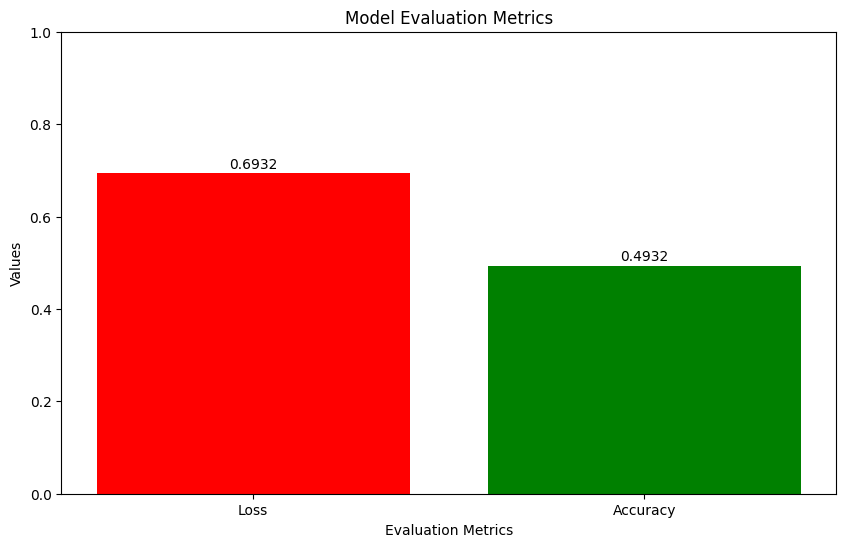

In [14]:
import matplotlib.pyplot as plt

# Metrics to plot
metrics = ['Loss', 'Accuracy']
values = [loss, accuracy]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['red', 'green'])

# Adding the numerical data on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 4), ha='center', va='bottom')

plt.xlabel('Evaluation Metrics')
plt.ylabel('Values')
plt.title('Model Evaluation Metrics')
plt.ylim(0, 1)  # Assuming loss is also between 0 and 1 for consistency; adjust if necessary
plt.show()
